In [1]:
import os
import sys
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from IPython.core.display import clear_output, display
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df, get_pd_line_graph, \
    apply_nodes_restrictions, apply_edge_restriction, construct_output_graph
from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical


import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


C:\Miniconda3\envs\ariadne_gpu\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [3]:
from scipy.interpolate import make_interp_spline, BSpline

def boxplot_style_data(bp):
    for box in bp['boxes']:
            # change outline color
        #box.set( color='#7570b3', linewidth=2)
            # change fill color
        box.set( facecolor = 'silver' )
    
    ## change color and linewidth of the whiskers
    #for whisker in bp['whiskers']:
    #    whisker.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the caps
    #for cap in bp['caps']:
    #    cap.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='tab:cyan', linewidth=3, alpha=0)

    for median in bp['means']:
        median.set(color='tab:green', linewidth=4, ls='-', zorder=5)
    #
    ### change the style of fliers and their fill
    #for flier in bp['fliers']:
    #    flier.set(marker='o', color='#e7298a', alpha=0.5)

def draw_from_data(title, data_x, data_y, data_y_err, axis_x=None, axis_y=None, **kwargs):
    data_x = np.array(data_x)
    data_y_init = np.array(data_y)
    dataep = data_y + np.array(data_y_err)
    dataem = data_y - np.array(data_y_err)

    data_y = np.expand_dims(data_y,axis=-1)
    dataep = np.expand_dims(dataep,axis=-1)
    dataem = np.expand_dims(dataem,axis=-1)

    data_y = np.concatenate((data_y, dataep, dataem), axis=1).T
    
    plt.figure(figsize=(8,7))

    ax = plt.subplot(111)
    
    plt.title(title, fontsize=14)
    plt.locator_params(axis='x', nbins=len(data_x) + 1)
    delta_x = (data_x[1]-data_x[0]) / 2
    bp = plt.boxplot(data_y, positions=data_x, 
                    manage_ticks=False, meanline=True, showmeans=True,
                    widths=delta_x,patch_artist=True, sym='',zorder=3)

    xnew = np.linspace(data_x.min(), data_x.max(), len(data_x)) 
    if axis_x:        
        plt.xlabel(axis_x, fontsize=12)
    if axis_y:
        plt.ylabel(axis_y, fontsize=12)
    mean_data = data_y_init
    spl = make_interp_spline(data_x, mean_data, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    if 'mean_label' in kwargs:
        label = kwargs['mean_label']
    else:
        label = 'mean efficiency'
    plt.plot(xnew, power_smooth, ls='--', color='tab:orange', label=label, lw=3, zorder=4)

    boxplot_style_data(bp)
    ax.grid()
    ax.legend(loc=0)
    if data_y.max() < 1.1:
        plt.yticks(np.round(np.linspace(0, 1, 11), decimals=2))
    if 'scale' in kwargs:
        plt.yscale(kwargs['scale'])
    plt.tight_layout()
    plt.rcParams['savefig.facecolor']='white'
    os.makedirs('../output', exist_ok=True)
    plt.savefig('../output/%s.png'%(''.join([i if (ord(i) < 128) and (ord(i)>ord('a')) else '_' for i in title])), dpi=300)
    plt.show()

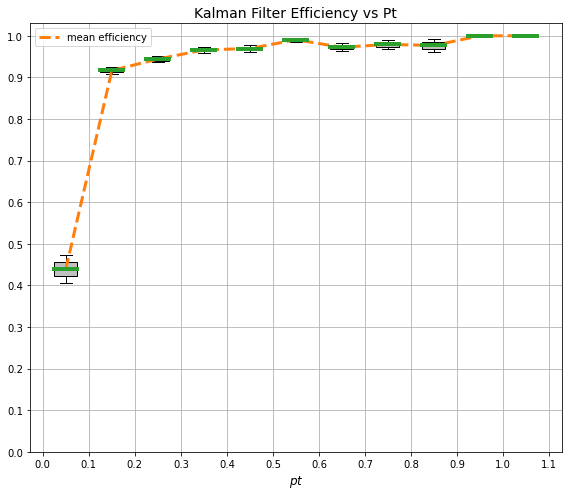

In [4]:
draw_from_data(title = "Kalman Filter Efficiency vs Pt",
               data_x=[ 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05],
               data_y=[0.439614, 0.916571, 0.943983, 0.966013, 0.969349, 0.990453, 0.972414, 0.979275, 0.976744, 1, 1],
               data_y_err=[0.034498, 0.00934838, 0.00740631, 0.00655114, 0.00754448, 0.00475043, 0.00961773, 0.0102547, 0.016252, 0, 0],
               axis_x="$pt$")

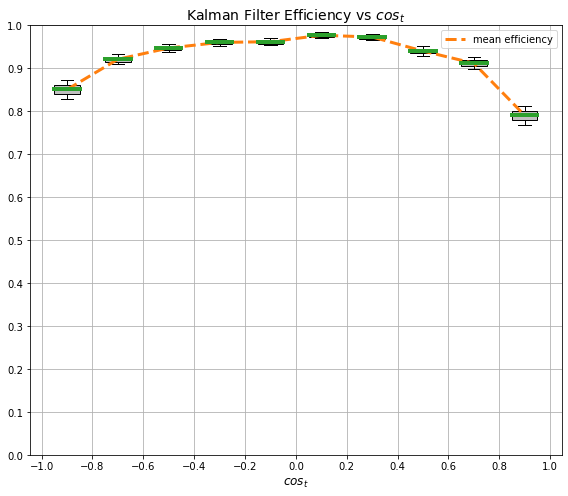

In [5]:
draw_from_data(title = "Kalman Filter Efficiency vs $cos_t$",
               data_x=[ -0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9],
               data_y=[0.850694, 0.921105, 0.947368, 0.960334, 0.962025, 0.977011, 0.972973, 0.940265, 0.911765, 0.790274],
               data_y_err=[0.0210004, 0.0119723, 0.0102456, 0.00891769, 0.00877912, 0.00718556, 0.00739396, 0.0111473, 0.0134912, 0.0224449],
               axis_x="$cos_t$")

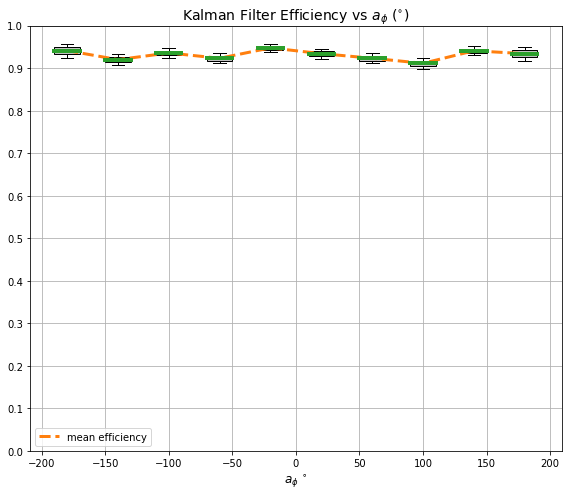

In [6]:
draw_from_data(title = "Kalman Filter Efficiency vs $a_\phi$ ($^{\circ}$)",
               data_x=[-180, -140, -100, -60, -20, 20, 60, 100, 140, 180],
               data_y=[0.941463, 0.920168, 0.935872, 0.923379, 0.947791, 0.934354, 0.923387, 0.911523, 0.940945, 0.934211],
               data_y_err=[0.016396, 0.0124228, 0.0109669, 0.0117897, 0.00996813, 0.0115851, 0.0119427, 0.012882, 0.0104587, 0.0164185],
               axis_x="$a_\phi$ $^{\circ}$")

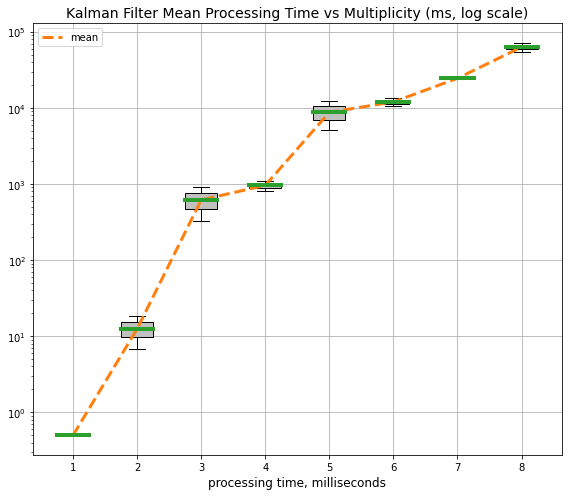

In [7]:
draw_from_data(title = "Kalman Filter Mean Processing Time vs Multiplicity (ms, log scale)",
               data_x=[1, 2, 3, 4, 5, 6, 7, 8],
               data_y=[0.5, 12.5, 616.4, 957.1, 8745.79, 11953.2, 24425.5, 62889.5],
               data_y_err=[0, 5.65685, 289.407, 151.376, 3604.46, 1505.82, 0, 8195.4],
               axis_x="processing time, milliseconds",
               scale='log',
               mean_label='mean')